<a href="https://colab.research.google.com/github/wlsisl/ESAA_/blob/main/%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07. 이미지 분할

이미지 분할 :이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것

즉, 모든 픽셀은 어떤 클래스에 속한다. 예를 들어 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 두 가지 클래스로 분류된다. 배경인지 객체인지 레이블이 달린 데이터를 통해 훈련시키고, 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있다.

### 7-1. 데이터셋 준비

* class 1 : 반려동물이 속한 픽셀(다음 그림의 노란색 영역)
* class 2 : 반려동물과 인접한 픽셀(빨간색 영역)
* class 3 : 위에 속하지 않는 경우/ 주변 픽셀(파란색 영역)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow


In [2]:
# 이미지 크기
img_w=128
img_h=128
img_c=3
img_shape=(img_w, img_h, img_c)

# 모델 학습
epoch_num=5
learning_rate=0.0001
buffer_size=1000
batch_size=16

In [3]:
# 텐서플로 데이터셋 로드, 메타 정보 가져와 info 변수에 저장
ds_str='oxford_iiit_pet'
ds, info=tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP3AKLN/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP3AKLN/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


다음은 원본이미지와 분할 마스크를 전처리하는 함수를 정의한다. 이미지의 픽셀을 255로 나눠서 0~1 범위로 정규화한다. 마스크는 0,1,2의 정수형 값을 갖도록 1을 차감한다.

In [4]:
# 이미지 전처리 함수
def preprocessing_image(ds):

  # 원본 이미지
  img=tf.image.resize(ds['image'], (img_w, img_h))
  img=tf.cast(img, tf.float32)/255.0

  # 분할 마스크
  mask=tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask=tf.cast(mask, tf.int32)
  mask=mask-1
  return img, mask

In [5]:
# 데이터 전처리 파이프라인
train_ds=ds['train'].map(preprocessing_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds=ds['test'].map(preprocessing_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 1개 선택, 배치에는 16개의 샘플이미지와 마스크 이미지가 잇음.
img, mask=next(iter(train_ds))
len(img)

16

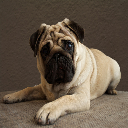

In [7]:
# 샘플 이미지 출력
img=np.array(img[0])*255.0
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

마스크 값의 범위는 0~2이므로 2로 나눈 다음에 255를 곱하면 RGB이미지로 표현할 수 있다.

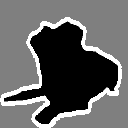

In [8]:
# 샘플 마스크 출력
mask=(np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 7-2. U-Net 모델

사전에 학습된 VGG16모델을 인코더로 활용하는 U-Net 모델을 만들어보자.

In [9]:
# VGG16 모델
base_model=tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


* VGG16 모델

해당 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖는다. 다음 코드의 실행결과는 (128,128) 크기의 텐서가 마지막 레이어에서는 (4,4) 크기로 축소되는 것을 확인할 수 있다.

인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소한다.

즉, 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역할을 한다.


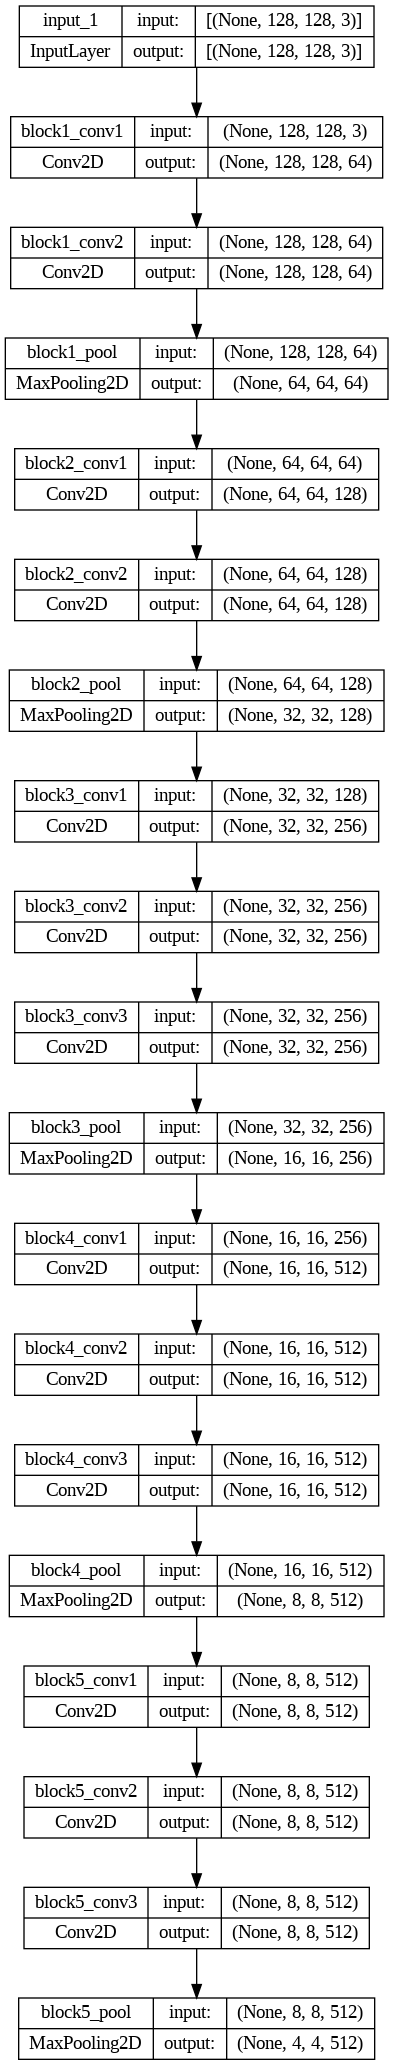

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 정한다.

VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처를 추출하는 인코더 모델을 정의하게 된다.

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output])

사전 학습된 파라미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정한다.

In [12]:
# 파라미터 고정
f_model.trainable=False

인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링한다.

업샘플링은 축소된 이미지를 원래 이미지 크기로 복원하는 과정이다.

In [13]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64=f_model(i)

out=tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out=tf.keras.layers.Add()([out, out_16_16_512])

out=tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_32_32_256])

out=tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_64_64_128])

out=tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out=tf.keras.layers.Add()([out, out_128_128_64])

out=tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out=tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model=tf.keras.Model(inputs=[i], outputs=[out])

* u-net 디코더를 구성할 때 입력 텐서와 출력 텐서의 크기를 맞추는 과정이 중요하다.

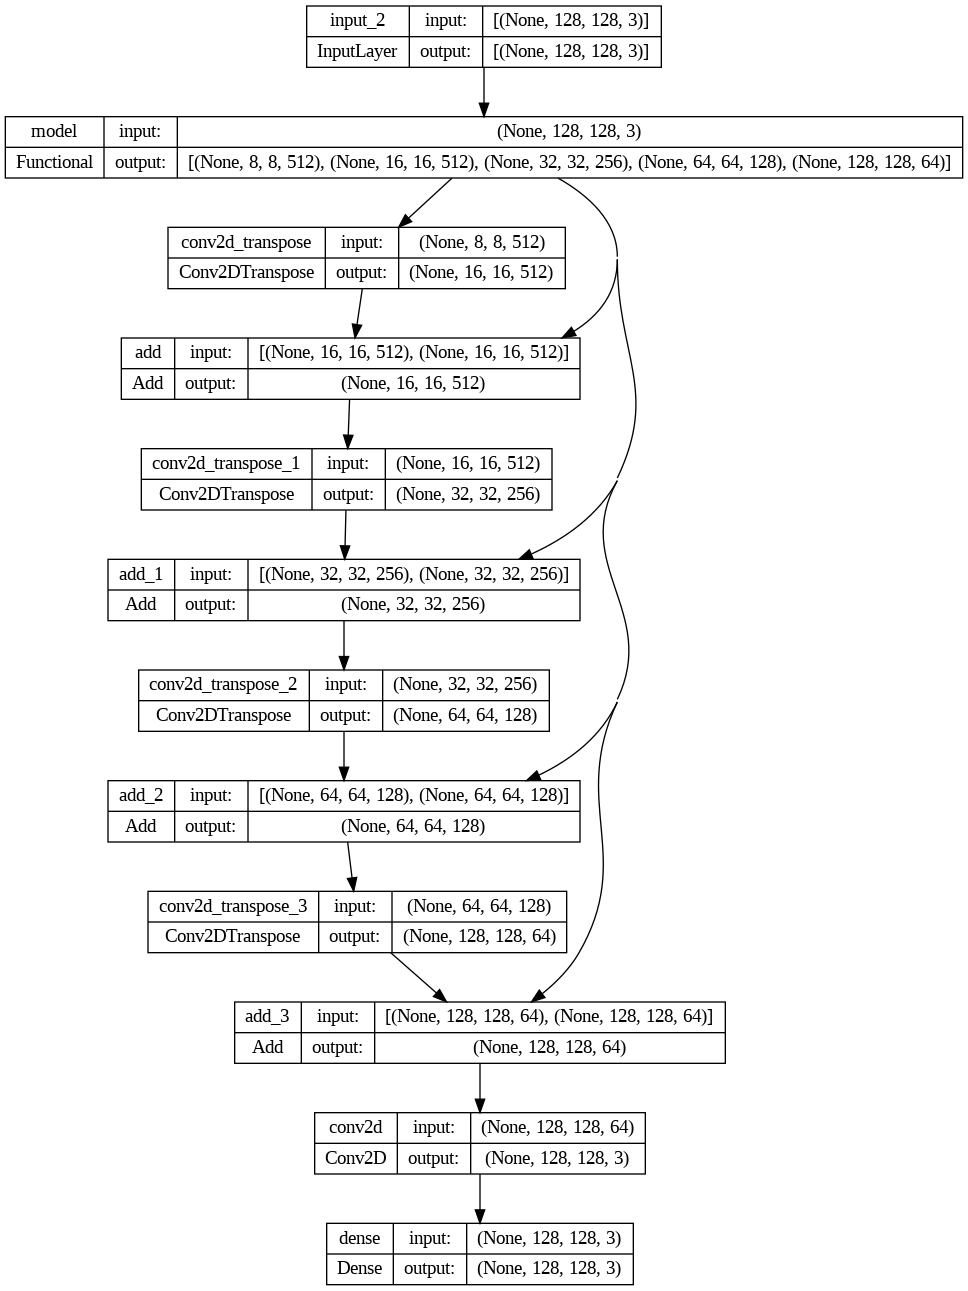

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
#모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [17]:
# 모델 컴파일 및 훈련
loss_f=tf.losses.SparseCategoricalCrossentropy()
opt=tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1537s 7s/step - loss: 0.4933 - accuracy: 0.8143
Epoch 2/5
230/230 [==============================] - 1506s 7s/step - loss: 0.4201 - accuracy: 0.8414
Epoch 3/5
230/230 [==============================] - 1503s 7s/step - loss: 0.3939 - accuracy: 0.8494
Epoch 4/5
230/230 [==============================] - 1498s 7s/step - loss: 0.3808 - accuracy: 0.8533
Epoch 5/5
230/230 [==============================] - 1508s 7s/step - loss: 0.3745 - accuracy: 0.8554


검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스를 예측한다.

1/1 [==============================] - 9s 9s/step


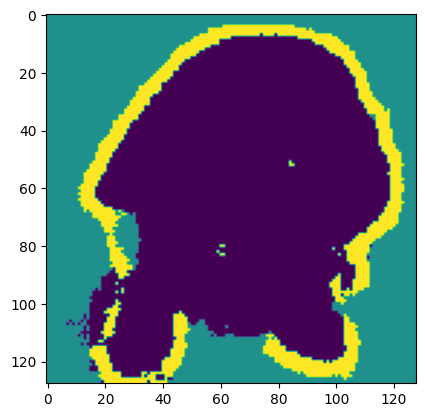

In [18]:
# 1개 매치 (16개 이미지)를 선택
img, mask=next(iter(test_ds))

# 모델 예측
pred=unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

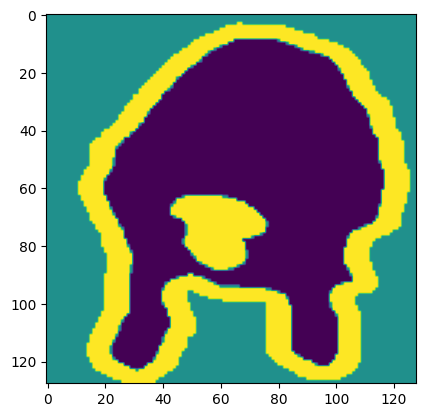

In [19]:
# 첫번재 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128, 128)))